# Overview

----

- [Kaggle URL](https://www.kaggle.com/c/nyc-taxi-trip-duration)
- [Kaggle뽀개기 URL](https://github.com/KaggleBreak/walkingkaggle/blob/master/taxi/Python/park/0906.%20Univariate%20Graph%20.ipynb)
- In this competition, **<u>Kaggle is challenging you to build a model that predicts the total ride duration of taxi trips in New York City.</u>** 
- Your primary dataset is one released by the NYC Taxi and Limousine Commission, which includes pickup time, geo-coordinates, number of passengers, and several other variables.

- Longtime Kagglers will recognize that this competition objective is similar to the [ECML/PKDD trip time challenge](https://www.kaggle.com/c/pkdd-15-taxi-trip-time-prediction-ii) we hosted in 2015. But, this challenge comes with a twist. Instead of awarding prizes to the top finishers on the leaderboard, this playground competition was created to reward collaboration and collective learning. 

We are encouraging you ([with cash prizes!](https://www.kaggle.com/c/nyc-taxi-trip-duration#Prizes)) to publish additional training data that other participants can use for their predictions. We also have designated bi-weekly and final prizes to reward authors of [kernels](https://www.kaggle.com/c/nyc-taxi-trip-duration/kernels) that are particularly insightful or valuable to the community.

# Data Description

----

- The competition dataset is based on the [2016 NYC Yellow Cab trip record data](https://cloud.google.com/bigquery/public-data/nyc-tlc-trips) made available in Big Query on Google Cloud Platform. 
- The data was originally published by the [NYC Taxi and Limousine Commission (TLC)](http://www.nyc.gov/html/tlc/html/about/trip_record_data.shtml). 
- The data was sampled and cleaned for the purposes of this playground competition. 
- Based on individual trip attributes, participants should predict the duration of each trip in the test set.

## File descriptions

- **train.csv** - the training set (contains 1458644 trip records)
- **test.csv** - the testing set (contains 625134 trip records)
- **sample_submission.csv** - a sample submission file in the correct format

## Data fields

- **id** - a unique identifier for each trip
- **vendor_id** - a code indicating the provider associated with the trip record
- **pickup_datetime** - date and time when the meter was engaged
- **dropoff_datetime** - date and time when the meter was disengaged
- **passenger_count** - the number of passengers in the vehicle (driver entered value)
- **pickup_longitude** - the longitude where the meter was engaged
- **pickup_latitude** - the latitude where the meter was engaged
- **dropoff_longitude** - the longitude where the meter was disengaged
- **dropoff_latitude** - the latitude where the meter was disengaged
- **store_and_fwd_flag** - This flag indicates whether the trip record was held in vehicle memory before sending to the vendor because the vehicle did not have a connection to the server - Y=store and forward; N=not a store and forward trip
- **trip_duration** - duration of the trip in seconds

Disclaimer: The decision was made to not remove dropoff coordinates from the dataset order to provide an expanded set of variables to use in Kernels.

- 여기에 타이타닉 예제를 적용하는 것이 더 낫겠다.
- 아울러, 최적의 변수를 자동으로 넣어주는 알고리즘을 더해주면 더 좋겠다.
- value는 trip_duration. 나머지는 잠재적 독립요인이라고 판단하는 것이지.

# Set Up

----

In [4]:
!pip install haversine

  Using cached haversine-0.4.5.tar.gz
  Running setup.py bdist_wheel for haversine ... done
  Stored in directory: /Users/pingonfefalas/Library/Caches/pip/wheels/be/a3/4e/2e073dc725bf9b430e2d42931c55e5be2be4cdc6e325e17677
Successfully built haversine


In [6]:
! pip install imread

In [8]:
!pip install Pillow==2.6.0

    100% |████████████████████████████████| 7.5MB 110kB/s ta 0:00:01
  Running setup.py bdist_wheel for Pillow ... done
  Stored in directory: /Users/pingonfefalas/Library/Caches/pip/wheels/fb/e0/07/bede53b9f65c0bb3fa37ef9f42bb8023a7b0c88f10216da1d3
Successfully built Pillow


In [2]:
!pip install sklearn

    100% |████████████████████████████████| 8.0MB 98kB/s  eta 0:00:01


In [6]:
!pip install plotly

    100% |████████████████████████████████| 1.1MB 686kB/s eta 0:00:01
  Running setup.py bdist_wheel for plotly ... done
  Stored in directory: /Users/pingonfefalas/Library/Caches/pip/wheels/43/3c/d9/7bb55474a73f126f3c52b2591850df6480f4f55138ea819d84
Successfully built plotly


In [8]:
!pip install bokeh

    100% |████████████████████████████████| 15.7MB 50kB/s  eta 0:00:01
    100% |████████████████████████████████| 256kB 2.7MB/s eta 0:00:01
  Running setup.py bdist_wheel for bokeh ... done
  Stored in directory: /Users/pingonfefalas/Library/Caches/pip/wheels/80/14/83/a01ff14e74f69cd31122aeff20bc3f5a804f05fcb28bab365d
  Running setup.py bdist_wheel for PyYAML ... done
  Stored in directory: /Users/pingonfefalas/Library/Caches/pip/wheels/2c/f7/79/13f3a12cd723892437c0cfbde1230ab4d82947ff7b3839a4fc
Successfully built bokeh PyYAML


In [5]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.cluster import KMeans
from sklearn.neighbors import KNeighborsClassifier
import time
from sklearn.cluster import KMeans # for doing K-means clustering
from haversine import haversine 
from scipy.misc import imread, imresize, imsave  # for plots 
import plotly.plotly as py
import plotly.graph_objs as go
import plotly
from bokeh.palettes import Spectral4
from bokeh.plotting import figure, output_notebook, show
from bokeh.layouts import gridplot
plotly.offline.init_notebook_mode() # run at the start of every ipython notebook
color = sns.color_palette()

IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.


In [6]:
def preprocess(): #str로 저장된 날짜를 datetime포맷으로 변환
    df_train = pd.read_csv('train.csv')
    df_test = pd.read_csv('test.csv')
    #df_train.drop(['id', 'store_and_fwd_flag'], axis = 1, inplace = True)
    #df_test.drop(['id', 'store_and_fwd_flag'], axis = 1, inplace = True)
    df_train[['pickup_datetime', 'dropoff_datetime']] = df_train[['pickup_datetime', 'dropoff_datetime']].apply(pd.to_datetime, errors='coerce')
    df_test[['pickup_datetime']] = df_test[['pickup_datetime']].apply(pd.to_datetime, errors='coerce')
    
    return df_train, df_test
train_df, test_df = preprocess() # 'process' 함수를 2개의 dataframe에 적용

In [49]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1458644 entries, 0 to 1458643
Data columns (total 11 columns):
id                    1458644 non-null object
vendor_id             1458644 non-null int64
pickup_datetime       1458644 non-null datetime64[ns]
dropoff_datetime      1458644 non-null datetime64[ns]
passenger_count       1458644 non-null int64
pickup_longitude      1458644 non-null float64
pickup_latitude       1458644 non-null float64
dropoff_longitude     1458644 non-null float64
dropoff_latitude      1458644 non-null float64
store_and_fwd_flag    1458644 non-null object
trip_duration         1458644 non-null int64
dtypes: datetime64[ns](2), float64(4), int64(3), object(2)
memory usage: 122.4+ MB


There were no null instances in train data! Our journey seemed to be happy :) <br/>

# check distribution of trip_duration

----

- From now on, **we are going to see the distribution of Y variables what we predict** 
- And then we have a time to **consider what we should draw during EDA.**

##### tips before you run next script:
- [np.log1p()](https://www.evernote.com/l/AQXGi8Q3wgNGN5Z_h6VisjaFka-4KI-YKnI)
- [seaborn.distplot](https://seaborn.pydata.org/generated/seaborn.distplot.html)
:Flexibly plot a univariate(단변량) distribution of observations.
This function combines the matplotlib hist function (with automatic calculation of a good default bin size) with the seaborn kdeplot() and rugplot() functions.
It can also fit scipy.stats distributions and plot the estimated PDF over the data.

Time taken by above cell is -4.00553393364


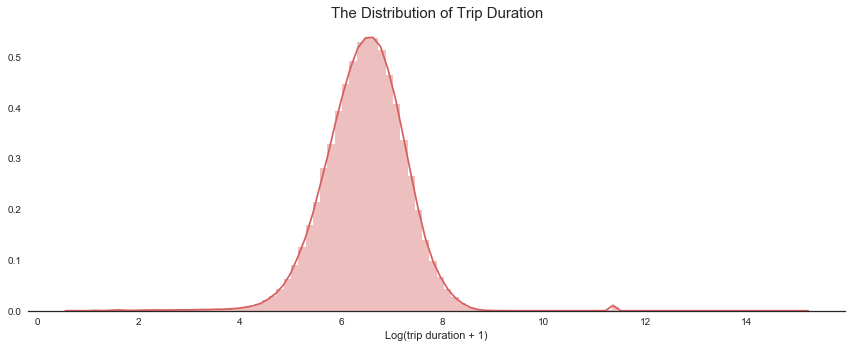

In [8]:
start = time.time()
sns.set(style = "white", palette = "muted", color_codes = True)
f, axes = plt.subplots(1,1, figsize = (12, 5), sharex = True)
sns.despine(left = True)
sns.distplot(np.log1p(train_df["trip_duration"].values), axlabel = "Log(trip duration + 1)", label = "Trip Duration", bins = 100, color = "r") #???

#plt.setp(axes, yticks = [])
plt.title("The Distribution of Trip Duration", fontsize = 15)
plt.tight_layout()
end = time.time()
print("Time taken by above cell is {}".format(start - end))
plt.show()

##### tips before you run next script:
- [stats.normaltest](https://www.evernote.com/shard/s261/sh/fdf7ac62-6de5-48ec-b39d-598b1ac9451a/f223de5029da7b98e32484c2542b5001)

In [9]:
import scipy.stats as stats
stats.normaltest(np.log1p(train_df["trip_duration"].values))

NormaltestResult(statistic=148792.90978954008, pvalue=0.0)

- It looked like to a normal distribution, 
- but the distribution was never normal if the pvalue is near 0 according to normaltest by stats. 
- However what we seized from the distribution, the data was spreaded out from the mean value.
 - https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.normaltest.html
 - https://stackoverflow.com/questions/12838993/scipy-normaltest-how-is-it-used

# Which features should we focus?

----


#### What kind of categorical values was in the data? --> categorical = [vendor_id, pos] 

1. On the surface, the variable 'vendor_id' means where each instance comes from. 
2. On the surface, there is the variable 'id'. However it didn't have a direct meaning to which we interpret, but just assisted us to count the number of instances in a group. 
3. On the inside of data, we should see the area of NYC, such as Mahatten and Brooklyn. 

4. In my opinion, the variable 'store and fwd flag' was meaningless. Here is the explanation in the Kaggle data description. 

 4.1. This flag indicates whether the trip record was held in vehicle memory before sending to the vendor because the vehicle did not have a connection to the server - Y=store and forward; N=not a store and forward trip

 4.2. It just said the system of each taxi is new or old! I guessed that the variable 'vendor id' influenced to 'store and fwd flag'.

#### What kind of continuous values was in the data? continous =  [passenger_count, trip_duration]
    1. passenger_count 
    2. trip_duration
I will keep tracking whether further continous variables exists or not. 

# Set Direction

----

- I am interested in time traveling regard of pickup_hour, day_of_week, day_of_month, month(which almost looked like similar with day_of_year, I guess).

- if the dataframe was grouped by catgorical, then showing cat / con values with the time flow seemed to be nicer and friendly let us know the meaning of the dataframe.




#### ActionItem 1. Preprocess

1. 뉴욕의 각 지역을 K means를 활용한 위치 데이터로 나누도록 한다.
2. time data를 판다스의 to_datetime().dt.xxx로 만들어 보도록 하자.

    
#### ActionItem 2. Draw graph

1. 단변량 그래프를 그려보자.
2. 다변량 그래프와 시계열 그래프를 그려보자!



# 1. Now time for to divde the area of NYC!

----

- Before going the trip, we saw the distribution of longtitude and latitude to exclude outliers from our data. 
- And then we used K-means with scikit learn into longtitude and latitude data. 
- From those datas, we indirectly extracted the neighbors of NYC. 

```
- 시작하기 전에 데이터에서 특이치를 제외하기 위해 경도와 위도 분포를 살펴보았다. 
- 그리고 나서 sklearn의 k-means알고리즘을 longitude와 latitude에 적용해보았다.
- 그 데이터들로부터 NYC의 각 지역을 간접적으로 추출했음.
```

**tips before you run next script:**
   - [plt.subplots()](https://matplotlib.org/devdocs/api/_as_gen/matplotlib.pyplot.subplots.html)
   - [seaborn.set()](http://seaborn.pydata.org/generated/seaborn.set.html) : 그래프의 기본적인 설정을 세팅한다.
   - [seaborn.despine](http://seaborn.pydata.org/generated/seaborn.despine.html):Remove the top and right spines from plot(s).
   - [seaborn.distplot](https://seaborn.pydata.org/generated/seaborn.distplot.html):
    - Flexibly plot a univariate(단변량) distribution of observations.
    - **This function combines the matplotlib hist function** (with automatic calculation of a good default bin size) with the seaborn kdeplot() and rugplot() functions. 
    - **It can also fit scipy.stats distributions and plot** the estimated PDF over the data.
   - [pyplot.setp](https://matplotlib.org/devdocs/api/_as_gen/matplotlib.pyplot.setp.html):
    - Set a property on an artist object.
    - matplotlib supports the use of setp() (“set property”) and getp() to set and get object properties, as well as to do introspection on the object.

### step1 : check distribution

- 택시 탑승 시의 위도와 경도=pickup_latitude,pickup_longitude
- 택시 하차 시의 위도와 경도=dropoff_latitude,dropoff_longitude
- 상기 좌표의 분포도를 그려보자

In [57]:
train_df.keys()

Index([u'id', u'vendor_id', u'pickup_datetime', u'dropoff_datetime',
       u'passenger_count', u'pickup_longitude', u'pickup_latitude',
       u'dropoff_longitude', u'dropoff_latitude', u'store_and_fwd_flag',
       u'trip_duration'],
      dtype='object')

In [59]:
train_df['store_and_fwd_flag'].unique()

array(['N', 'Y'], dtype=object)

Time taken by above cell is 12.2174499035


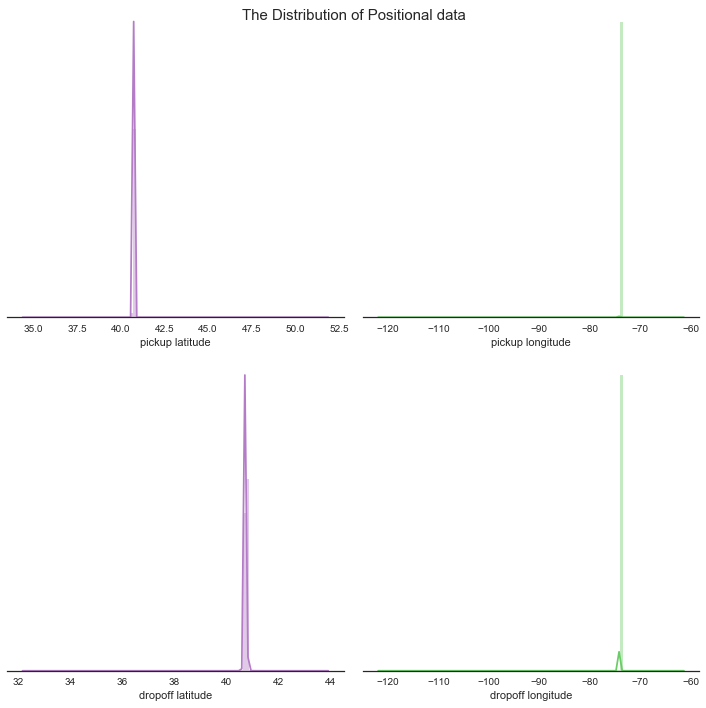

In [10]:
start = time.time() # 이 스크립트의 시작시간을 저장한다.
sns.set(style = "white", palette = "muted", color_codes = True) #그래프의 기본적인 설정을 세팅한다. 세부정보는 상기 명시된 tip을 참조한다.
f, axes = plt.subplots(2,2, figsize = (10,10), sharex = False, sharey = False)  #그래프의 기본적인 설정을 세팅한다. 세부정보는 상기 명시된 tip을 참조한다.
sns.despine(left = True) # 그래프의 테두리를 제거한다.

#'pickup_latitude' 그래프를 만든다.
sns.distplot(train_df["pickup_latitude"].values, axlabel = "pickup latitude", color = "m", bins = 100, ax = axes[0,0]) 

#'pickup_longitude' 그래프를 만든다.
sns.distplot(train_df["pickup_longitude"].values, axlabel = "pickup longitude", color = "g", bins = 100, ax = axes[0,1])

#'dropoff_latitude' 그래프를 만든다.
sns.distplot(train_df["dropoff_latitude"].values, axlabel = "dropoff latitude", color = "m", bins = 100, ax = axes[1,0])

#'dropoff_longitude' 그래프를 만든다.
sns.distplot(train_df["dropoff_longitude"].values, axlabel = "dropoff longitude", color = "g", bins = 100, ax = axes[1,1])


plt.setp(axes, yticks = [])
plt.suptitle("The Distribution of Positional data", fontsize = 15)
plt.tight_layout()
end = time.time()
print("Time taken by above cell is {}".format(end-start))
plt.show()

Wow those data sooooooooo dense on the little interval than the entire one. **We have to kick out of the outliers from each variables.How we do it?**  <br/>
    1. With percentile
    2. NYC offical position with map
We used **percentile** :)

### Step2 Remove Outlier 1

In [11]:
train_ny = train_df.copy()

In [62]:
print(
#np.percentile(train_df['pickup_latitude'].values, 0),
#np.percentile(train_df['pickup_latitude'].values, 100),#+alpha,
#train_df['pickup_latitude'].min(),
#train_df['pickup_latitude'].max(),
np.percentile(train_df['pickup_latitude'].values, 1),
np.percentile(train_df['pickup_latitude'].values, 99),#+alpha,   
)

(40.644824981689453, 40.806598663330078)


In [13]:
start = time.time()
alpha = 0.3
pick_max_lat = np.percentile(train_df['pickup_latitude'].values, 99) + alpha
pick_min_lat = np.percentile(train_df['pickup_latitude'].values, 1) - alpha
pick_max_long = np.percentile(train_df['pickup_longitude'].values, 99) + alpha
pick_min_long = np.percentile(train_df['pickup_longitude'].values, 1) - alpha

drop_max_lat = np.percentile(train_df['dropoff_latitude'].values, 99) + alpha
drop_min_lat = np.percentile(train_df['dropoff_latitude'].values, 1) - alpha
drop_max_long = np.percentile(train_df['dropoff_longitude'].values, 99) + alpha
drop_min_long = np.percentile(train_df['dropoff_longitude'].values, 1) - alpha

train_ny = train_ny.loc[(pick_min_lat < train_df['pickup_latitude']) & (train_df['pickup_latitude'] < pick_max_lat)]
train_ny = train_ny.loc[(pick_min_long < train_df['pickup_longitude']) & (train_df['pickup_longitude'] < pick_max_long)]
train_ny = train_ny.loc[(drop_min_lat < train_df['dropoff_latitude']) & (train_df['dropoff_latitude'] < drop_max_lat)]
train_ny = train_ny.loc[(drop_min_long < train_df['dropoff_longitude']) & (train_df['dropoff_longitude'] < drop_max_long)]

end = time.time()
print("Time taken by above cell is {}".format(end-start))

Time taken by above cell is 0.906085968018


Time taken by above cell is 12.980905056


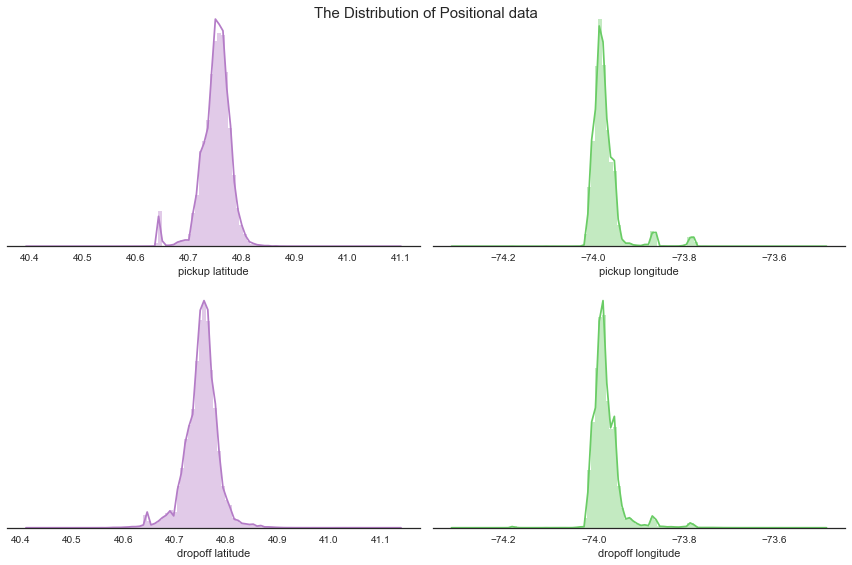

In [14]:
start = time.time()
sns.set(style = "white", palette = "muted", color_codes = True)
fig, axes = plt.subplots(2,2, figsize = (12, 8), sharex = False, sharey = False)
sns.despine(left = True)
sns.distplot(train_ny["pickup_latitude"].values, axlabel = "pickup latitude", color = "m", bins = 100, ax = axes[0,0])
sns.distplot(train_ny["pickup_longitude"].values, axlabel = "pickup longitude", color = "g", bins = 100, ax = axes[0,1])
sns.distplot(train_ny["dropoff_latitude"].values, axlabel = "dropoff latitude", color = "m", bins = 100, ax = axes[1,0])
sns.distplot(train_ny["dropoff_longitude"].values, axlabel = "dropoff longitude", color = "g", bins = 100, ax = axes[1,1])
plt.setp(axes, yticks = [])
plt.suptitle("The Distribution of Positional data", fontsize = 15)
plt.tight_layout()
end = time.time()
print("Time taken by above cell is {}".format(end-start))
plt.show()

This is more rational :)

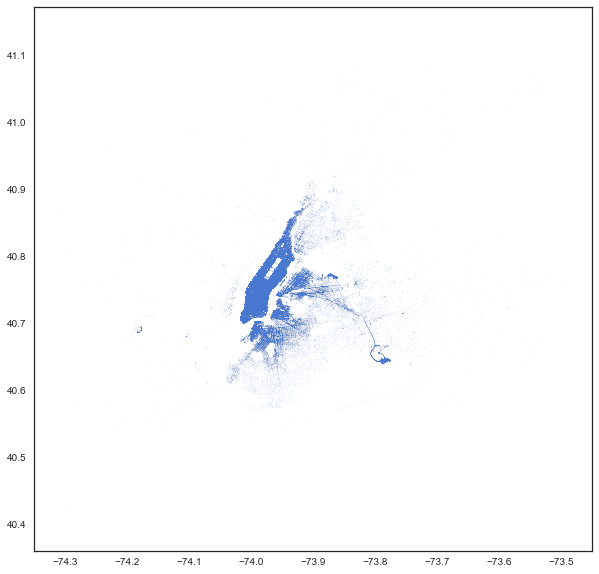

In [15]:
longitude = list(train_ny.pickup_longitude) + list(train_ny.dropoff_longitude)
latitude = list(train_ny.pickup_latitude) + list(train_ny.dropoff_latitude)
plt.figure(figsize = (10, 10))
plt.plot(longitude, latitude, '.', alpha = 0.4, markersize = 0.4)
plt.show()

It's was worse than what I have seen in Kaggle notebook. So I changed into a Kaggle notebook version.

Time taken by above cell is 15.2142620087
(1452385, 1452385)


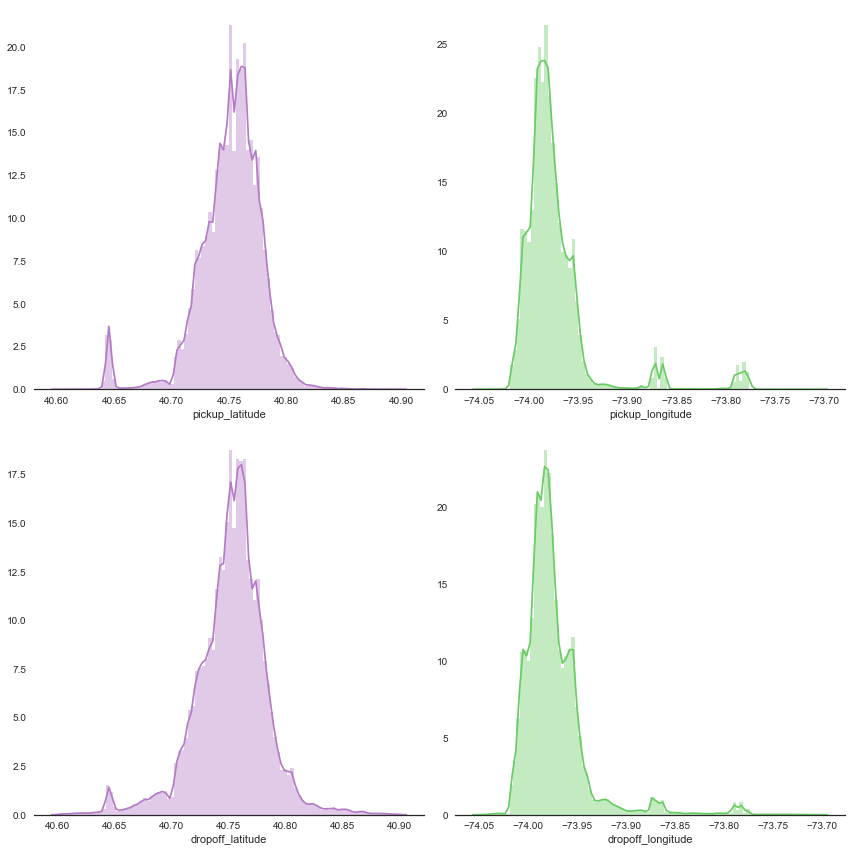

In [16]:
start = time.time()
train_ny = train_df.loc[(train_df.pickup_latitude > 40.6) & (train_df.pickup_latitude < 40.9)]
train_ny = train_ny.loc[(train_ny.dropoff_latitude>40.6) & (train_ny.dropoff_latitude < 40.9)]
train_ny = train_ny.loc[(train_ny.dropoff_longitude > -74.05) & (train_ny.dropoff_longitude < -73.7)]
train_ny = train_ny.loc[(train_ny.pickup_longitude > -74.05) & (train_ny.pickup_longitude < -73.7)]
sns.set(style = "white", palette = "muted", color_codes = True)
f, axes = plt.subplots(2,2, figsize = (12, 12), sharex = False, sharey = False)
sns.despine(left = True)
sns.distplot(train_ny['pickup_latitude'].values, axlabel = 'pickup_latitude', color = "m", bins = 100, ax = axes[0,0])
sns.distplot(train_ny['pickup_longitude'].values, axlabel = 'pickup_longitude', color = "g", bins = 100, ax = axes[0,1])
sns.distplot(train_ny['dropoff_latitude'].values, axlabel = 'dropoff_latitude', color = "m", bins = 100, ax = axes[1,0])
sns.distplot(train_ny['dropoff_longitude'].values, axlabel = 'dropoff_longitude', color = "g", bins = 100, ax = axes[1,1])
plt.tight_layout()
end = time.time()
print("Time taken by above cell is {}".format(end-start))
print(train_ny.shape[0], train_ny.shape[0])
plt.show()

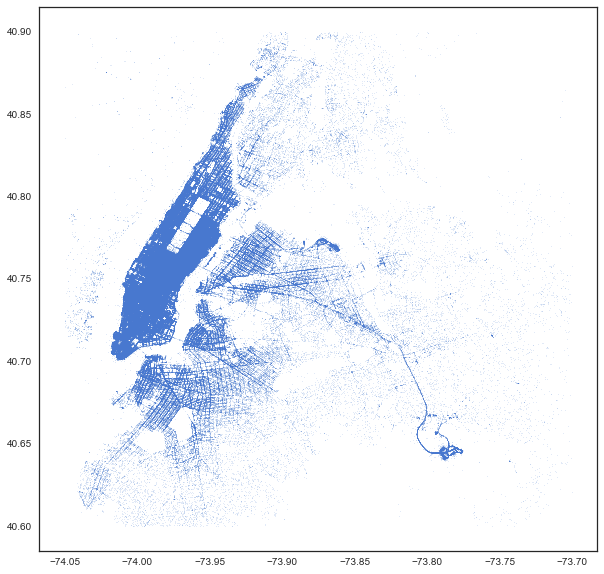

In [17]:
longitude = list(train_ny.pickup_longitude) + list(train_ny.dropoff_longitude)
latitude = list(train_ny.pickup_latitude) + list(train_ny.dropoff_latitude)
plt.figure(figsize = (10, 10))
plt.plot(longitude, latitude, '.', alpha = 0.4, markersize = 1)
plt.show()

In [18]:
train_ny[['pickup_datetime', 'dropoff_datetime']].to_csv('train_time.csv', index = False)

## Kmeans Classification

[kmeans](http://scikit-learn.org/stable/modules/generated/sklearn.cluster.KMeans.html)

- **n_clusters** : 
 - int, optional, default: 8
 - The number of clusters to form as well as the number of centroids to generate.

- **random_state** : 
 - int, RandomState instance or None, optional, default: None
 - If int, random_state is the seed used by the random number generator; 
 - If RandomState instance, random_state is the random number generator; 
 - If None, the random number generator is the RandomState instance used by np.random.

- **n_init** :
 - int, default: 10
 - Number of time the k-means algorithm will be run with different centroid seeds. 
 - The final results will be the best output of n_init consecutive runs in terms of inertia.

In [45]:
#start = time.time()
loc_df = pd.DataFrame()
loc_df['longitude'] = longitude
loc_df['latitude'] = latitude


kmeans = KMeans(n_clusters = 15, random_state = 2, n_init = 10).fit(loc_df)
loc_df['label'] = kmeans.labels_
#loc_df
loc_df = loc_df.sample(200000)
plt.figure(figsize = (10, 10))
for itr, label in enumerate(loc_df.label.unique()):
    label_index = loc_df[loc_df.label == label].index
    plt.plot(loc_df['longitude'].loc[label_index], loc_df['latitude'].loc[label_index],
            '.', alpha = 0.3, markersize = 0.3)
plt.title('Clusters of New York', fontsize = 15)
end = time.time()
print("Time taken by above cell is {}".format(end-start))
plt.show()





,longitude,latitude
0,-73.982155,40.767937
1,-73.980415,40.738564
2,-73.979027,40.763939
3,-74.010040,40.719971
4,-73.973053,40.793209
5,-73.982857,40.742195
6,-73.969017,40.757839
7,-73.969276,40.797779
8,-73.999481,40.738400
9,-73.981049,40.744339


Time taken by above cell is 268.120043039


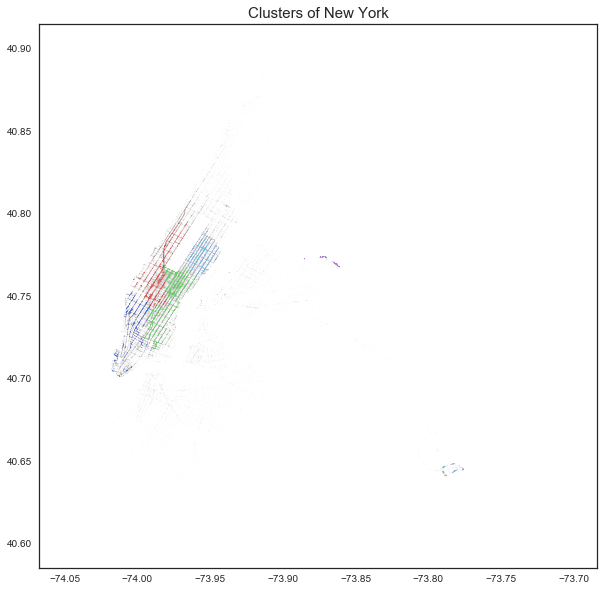

In [19]:
start = time.time()
loc_df = pd.DataFrame()
loc_df['longitude'] = longitude
loc_df['latitude'] = latitude


kmeans = KMeans(n_clusters = 15, random_state = 2, n_init = 10).fit(loc_df)
loc_df['label'] = kmeans.labels_

loc_df = loc_df.sample(200000)
plt.figure(figsize = (10, 10))
for itr, label in enumerate(loc_df.label.unique()):
    label_index = loc_df[loc_df.label == label].index
    plt.plot(loc_df['longitude'].loc[label_index], loc_df['latitude'].loc[label_index],
            '.', alpha = 0.3, markersize = 0.3)
plt.title('Clusters of New York', fontsize = 15)
end = time.time()
print("Time taken by above cell is {}".format(end-start))
plt.show()




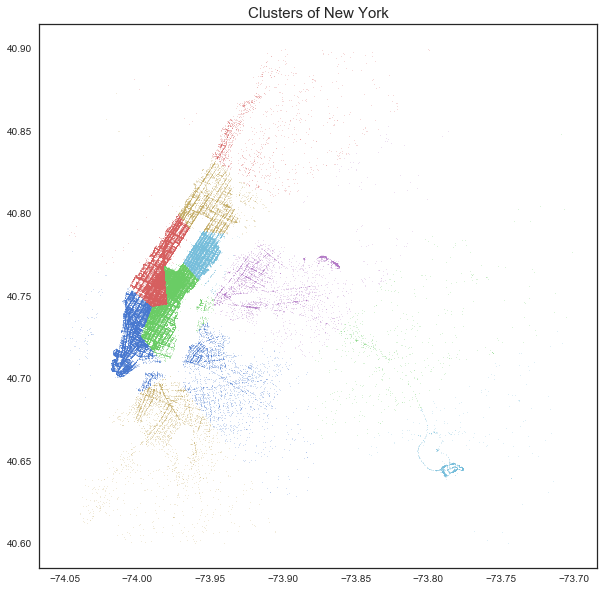

In [20]:
plt.figure(figsize = (10, 10))
for itr, label in enumerate(loc_df.label.unique()):
    label_index = loc_df[loc_df.label == label].index
    plt.plot(loc_df['longitude'].loc[label_index], loc_df['latitude'].loc[label_index],
            '.', alpha = 0.3, markersize = 2)
plt.title('Clusters of New York', fontsize = 15)
plt.show()

In [21]:
train_ny['pickup_pos'] = kmeans.predict(train_ny[['pickup_longitude','pickup_latitude']].values)
train_ny['dropoff_pos'] = kmeans.predict(train_ny[['dropoff_longitude','dropoff_latitude']].values)

In [22]:
train_ny.sample(3)

,id,vendor_id,pickup_datetime,dropoff_datetime,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,store_and_fwd_flag,trip_duration,pickup_pos,dropoff_pos
502104,id3064151,1,2016-01-30 14:32:56,2016-01-30 14:58:17,1,-74.003036,40.731274,-73.983444,40.735130,N,1521,9,0
614817,id1913865,2,2016-04-01 21:37:38,2016-04-01 21:52:22,1,-74.001366,40.756947,-73.981651,40.743702,N,884,4,0
310598,id1228058,2,2016-06-07 07:50:36,2016-06-07 08:03:29,1,-73.953804,40.774948,-73.972931,40.755466,N,773,1,10


In [23]:
def dividing_df(train_ny):
    """
    This function is for our multivariate graph.
    """
    start = time.time()
    train_time = pd.DataFrame(train_ny[['pickup_datetime', 'dropoff_datetime']].copy())
    train_time.loc[:, 'month'] = train_time['pickup_datetime'].dt.month
    train_time.loc[:, 'pickup_hour'] = train_time['pickup_datetime'].dt.hour
    train_time.loc[:, 'week_of_year'] = train_time['pickup_datetime'].dt.weekofyear
    train_time.loc[:, 'day_of_year'] = train_time['pickup_datetime'].dt.dayofyear
    train_time.loc[:, 'day_of_week'] = train_time['pickup_datetime'].dt.dayofweek
    cat_var = ['id', 'passenger_count', 'store_and_fwd_flag', 'trip_duration']
    con_var = ['vendor_id', 'pickup_pos', 'dropoff_pos'] # + the area in New York City
    train_con = train_ny[con_var]
    train_cat = train_ny[cat_var]
    end = time.time()
    print("Time taken by above cell : {}".format(end - start))


    train_con.to_csv('train_con.csv', index = False)
    train_cat.to_csv('train_cat.csv', index = False)
    train_time.to_csv('train_time.csv', index = False)
dividing_df(train_ny)
train_con = pd.read_csv('train_con.csv')
train_cat = pd.read_csv('train_cat.csv')
train_time = pd.read_csv('train_time.csv')

Time taken by above cell : 0.813014030457


In [24]:
train_time['pickup_datetime'] = pd.to_datetime(train_time['pickup_datetime'])
train_time.loc[:, 'month'] = train_time['pickup_datetime'].dt.month
train_time.loc[:, 'pickup_hour'] = train_time['pickup_datetime'].dt.hour
train_time.loc[:,'day'] = train_time['pickup_datetime'].dt.day
train_time.loc[:, 'week_of_year'] = train_time['pickup_datetime'].dt.weekofyear
train_time.loc[:, 'day_of_year'] = train_time['pickup_datetime'].dt.dayofyear
train_time.loc[:, 'day_of_week'] = train_time['pickup_datetime'].dt.dayofweek

Preparing data is finished let go to univariate and multivariate with time 

### 1. Univariate
        1. categorical, vendor_id, pickup/dropoff_pos
        2. continuous, passenger_count, trip_duration
        3. time, month, pickup_hour, week_of_year, day_of_year, day_of_week.

        1. Categorical, vendor_id, pickup/dropoff_pos

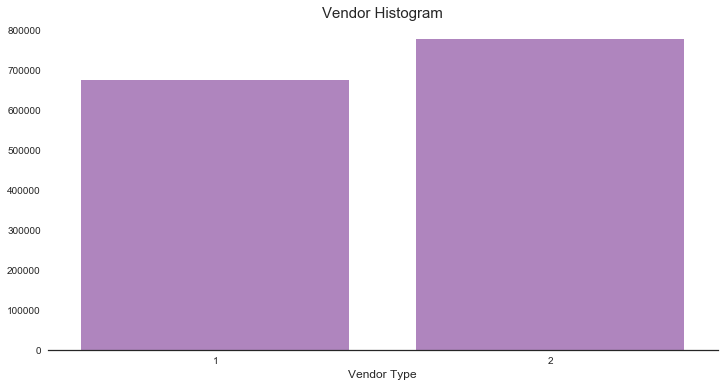

In [25]:
cnt_tmp = train_con['vendor_id'].value_counts()
cnt_tmp
sns.set(style = "white", palette = "muted", color_codes = True)
f, ax = plt.subplots(1,1, figsize = (12,6))
sns.despine(left = True)
sns.barplot(cnt_tmp.index, cnt_tmp.values, color = "m")
plt.xlabel("Vendor Type", fontsize = 12)
plt.title("Vendor Histogram", fontsize = 15)
plt.show()

Each size of vendor was not severly different.

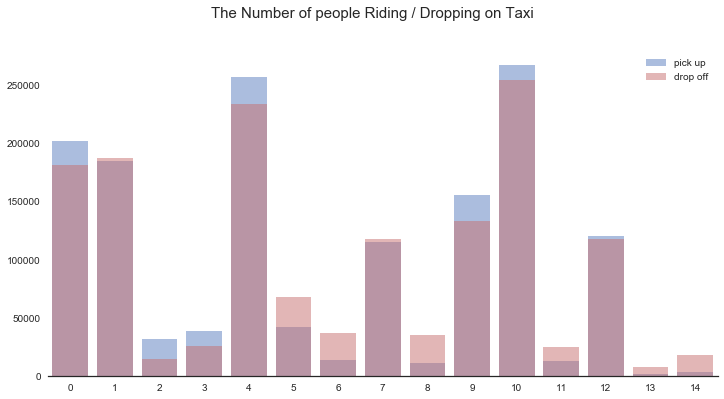

In [26]:
cnt_tmp = train_con['pickup_pos'].value_counts()
cnt_tmp2 = train_con['dropoff_pos'].value_counts()
sns.set(style = "white", palette = "muted", color_codes = True)
f, axes = plt.subplots(1,1, figsize = (12,6))
sns.despine(left = True)
sns.barplot(cnt_tmp.index, cnt_tmp.values, color = "b", label = "pick up", alpha = 0.5, ax = axes)
sns.barplot(cnt_tmp2.index, cnt_tmp2.values, color = "r", label = "drop off", alpha = 0.5,  ax = axes)
plt.legend()
plt.suptitle("The Number of people Riding / Dropping on Taxi", fontsize = 15)
plt.show()

Area 2,3 : People usually were riding. The meaning is when they came back, they perhaps used different traffic type. <br/>
Area 5,6,8,11,13, 14 : People generally got out of taxi in these area. Some of them maybe were waypoint or nightlife town on surburb of NYC.

        2. continous, passenger_count, trip_duration

            Trip_duration is same with what we have seen first. So skip.

In [27]:
train_df.keys()

Index([u'id', u'vendor_id', u'pickup_datetime', u'dropoff_datetime',
       u'passenger_count', u'pickup_longitude', u'pickup_latitude',
       u'dropoff_longitude', u'dropoff_latitude', u'store_and_fwd_flag',
       u'trip_duration'],
      dtype='object')

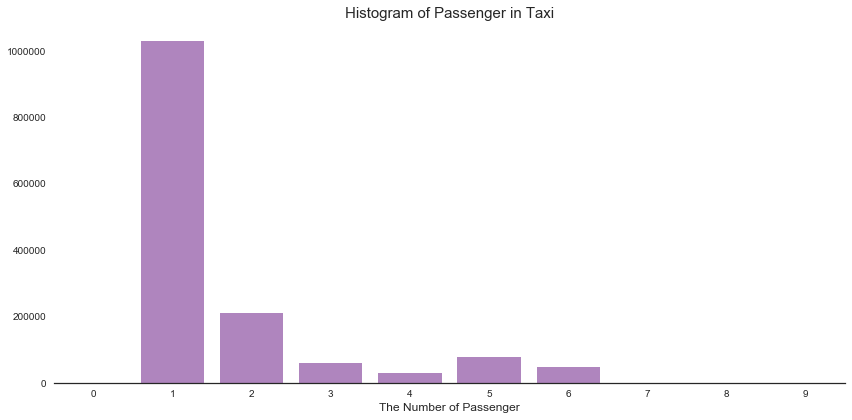

In [28]:
cnt_tmp = train_cat['passenger_count'].value_counts()
sns.set(style = "white", palette = "muted", color_codes = True)
f, axes = plt.subplots(1,1,figsize = (12,6))
sns.despine(left = True)
sns.barplot(cnt_tmp.index, cnt_tmp.values, color = "m")
plt.xlabel("The Number of Passenger", fontsize = 12)
plt.title("Histogram of Passenger in Taxi", fontsize = 15)
plt.tight_layout()
plt.show()

...0???

In [29]:
[(cnt_tmp == x).sum() for x in [0, 7, 8, 9]]

[0, 0, 0, 0]

Okay Okay, It's impossible. People in NY usually took a taxi alone.

        3. Time, month, pickup_hour, week_of_year, day_of_year, day_of_week.

In [30]:
print(len(train_time.columns))

8


### Now Have a time to evaluate sns.tsplot, sns.barplot, and bokeh line. <br/>
    [Result]
    * Using bokeh if you want to dramatically see the difference and decrease time to draw 
    * Using sns.tsplot if you want to dramatically see the difference 
    * Using sns.barplot, if you want to prove that the data doesn't have a severe difference.
    
    - In time effectiveness, bokeh line > sns.barplot > sns.tsplot
    - In dramatic effectiveness, bokeh line == sns.tsplot > sns.barplot
    
    

#### The Quantity of Taxi in Month

Time taken by above cell is 0.124676942825


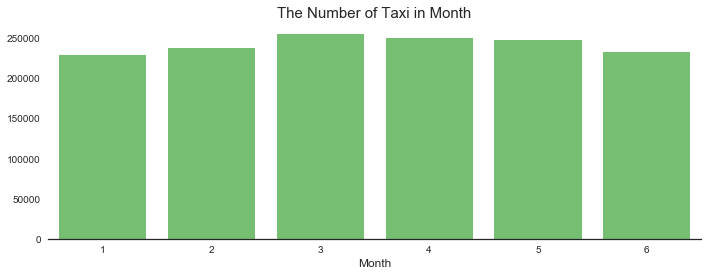

In [31]:
start = time.time()
cnt_tmp = train_time['month'].value_counts()
sns.set(style = "white", palette = "muted", color_codes = True)
f, axes = plt.subplots(1,1,figsize = (10,4))
sns.despine(left = True)
sns.barplot(cnt_tmp.index, cnt_tmp.values, color = "g")
plt.xlabel("Month", fontsize = 12)
plt.title("The Number of Taxi in Month", fontsize = 15)
plt.tight_layout()
end = time.time()
print("Time taken by above cell is {}".format(end - start))
plt.show()

/Users/pingonfefalas/anaconda/envs/python27/lib/python2.7/site-packages/seaborn/timeseries.py:183: UserWarning:

The tsplot function is deprecated and will be removed or replaced (in a substantially altered version) in a future release.



Time taken by above cell is 0.218905925751


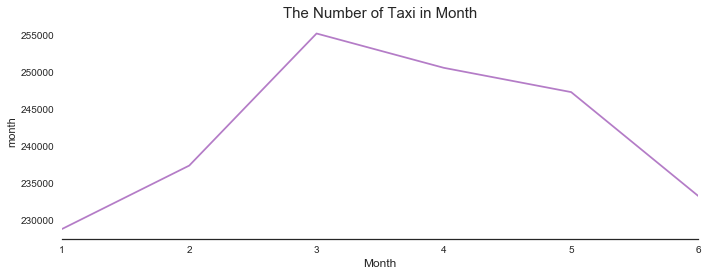

In [32]:
start = time.time()
cnt_tmp = train_time['month'].value_counts()
cnt_tmp = cnt_tmp.reset_index()
cnt_tmp['unit'] = 1
sns.set(style = "white", palette = "muted", color_codes = True)
f, axes = plt.subplots(1,1,figsize = (10,4))
sns.despine(left = True)
sns.tsplot(cnt_tmp, time = "index", value = "month", unit = "unit", color = "m")
plt.xlabel("Month", fontsize = 12)
plt.title("The Number of Taxi in Month", fontsize = 15)
plt.tight_layout()
end = time.time()
print("Time taken by above cell is {}".format(end - start))
plt.show()

#### The Quantity of Taxi in Hour

Time taken by above cell is 0.174684047699


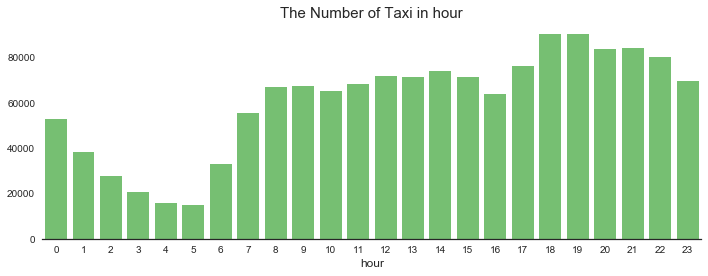

In [33]:
start = time.time()
cnt_tmp = train_time['pickup_hour'].value_counts()
sns.set(style = "white", palette = "muted", color_codes = True)
f, axes = plt.subplots(1,1,figsize = (10,4))
sns.despine(left = True)
sns.barplot(cnt_tmp.index, cnt_tmp.values, color = "g")
plt.xlabel("hour", fontsize = 12)
plt.title("The Number of Taxi in hour", fontsize = 15)
plt.tight_layout()
end = time.time()
print("Time taken by above cell is {}".format(end - start))
plt.show()

Time taken by above cell is 0.204347133636


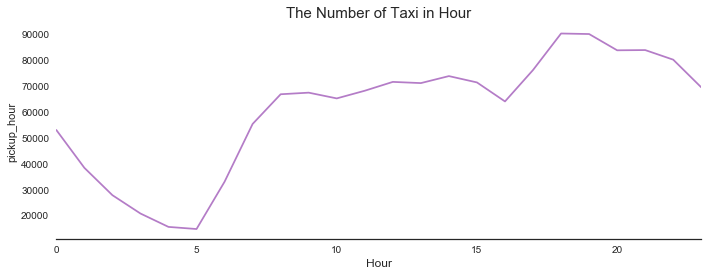

In [34]:
start = time.time()
cnt_tmp = train_time['pickup_hour'].value_counts()
cnt_tmp = cnt_tmp.reset_index()
cnt_tmp['unit'] = 1
sns.set(style = "white", palette = "muted", color_codes = True)
f, axes = plt.subplots(1,1,figsize = (10,4))
sns.despine(left = True)
sns.tsplot(cnt_tmp, time = 'index', value = 'pickup_hour', unit = 'unit', color = "m")
plt.xlabel("Hour", fontsize = 12)
plt.title("The Number of Taxi in Hour", fontsize = 15)
plt.tight_layout()
end = time.time()
print("Time taken by above cell is {}".format(end - start))
plt.show()

In [35]:
start = time.time()
output_notebook()
start = time.time()
cnt_tmp = train_time['pickup_hour'].value_counts()
cnt_tmp = cnt_tmp.reset_index()
cnt_tmp.sort_values('index', inplace = True)
p = figure(plot_width = 800, plot_height = 250)
p.title.text = "The Number of Taxi in Pickup Hour"
p.line(cnt_tmp['index'], cnt_tmp['pickup_hour'], line_width = 2, color = Spectral4[0], alpha = 0.8)
end = time.time()
print("Time taken by above cell is {}".format(end-start))
show(p)

Loading BokehJS ...

Time taken by above cell is 0.0351710319519


### The Quantity of Taxi in day_of_week

Time taken by above cell is 0.170931816101


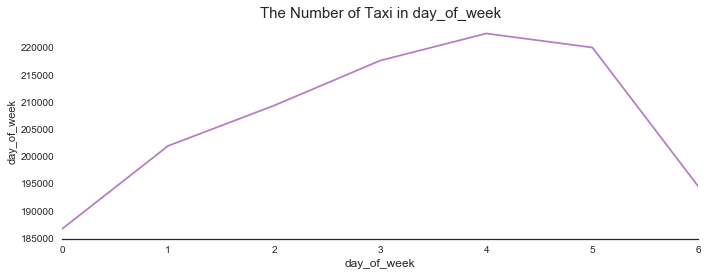

In [36]:
start = time.time()
cnt_tmp = train_time['day_of_week'].value_counts()
cnt_tmp = cnt_tmp.reset_index()
cnt_tmp['unit'] = 1
sns.set(style = "white", palette = "muted", color_codes = True)
f, axes = plt.subplots(1,1,figsize = (10,4))
sns.despine(left = True)
sns.tsplot(cnt_tmp, time = 'index', value = 'day_of_week', unit = 'unit', color = "m")
plt.xlabel("day_of_week", fontsize = 12)
plt.title("The Number of Taxi in day_of_week", fontsize = 15)
plt.tight_layout()
end = time.time()
print("Time taken by above cell is {}".format(end-start))
plt.show()

In [37]:
start = time.time()
output_notebook()
start = time.time()
cnt_tmp = train_time['day_of_week'].value_counts()
cnt_tmp = cnt_tmp.reset_index()
cnt_tmp.sort_values('index', inplace = True)
p = figure(plot_width = 800, plot_height = 250)
p.title.text = "The Number of Taxi in Day of Week"
p.line(cnt_tmp['index'], cnt_tmp['day_of_week'], line_width = 2, color = Spectral4[0], alpha = 0.8)
end = time.time()
print("Time taken by above cell is {}".format(end-start))
show(p)

Loading BokehJS ...

Time taken by above cell is 0.0347731113434


### The Quantity of taxi in day_of_week

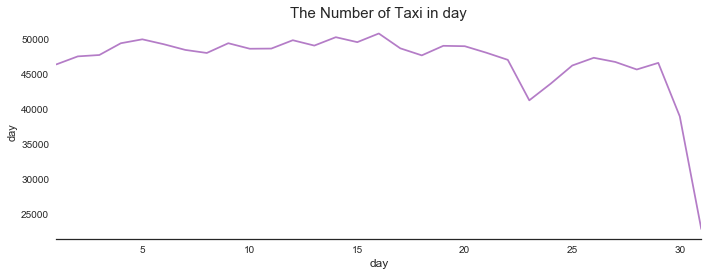

In [38]:
cnt_tmp = train_time['day'].value_counts()
cnt_tmp = cnt_tmp.reset_index()
cnt_tmp['unit'] = 1
sns.set(style = "white", palette = "muted", color_codes = True)
f, axes = plt.subplots(1,1,figsize = (10,4))
sns.despine(left = True)
sns.tsplot(cnt_tmp, time = 'index', value = 'day', unit = 'unit', color = "m")
plt.xlabel('day', fontsize = 12)
plt.title("The Number of Taxi in day", fontsize = 15)
plt.tight_layout()
plt.show()

### The Quantity of taxi in week_of_year

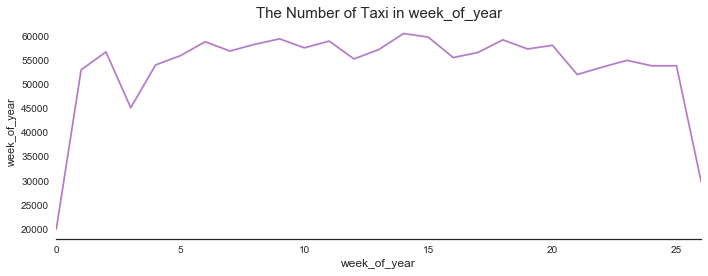

In [39]:
cnt_tmp = train_time['week_of_year'].value_counts()
cnt_tmp = cnt_tmp.reset_index()
cnt_tmp['unit'] = 1
cnt_tmp['index'].loc[cnt_tmp['index'] == 53] = 0
sns.set(style = "white", palette = "muted", color_codes = True)
f, axes = plt.subplots(1,1,figsize = (10,4))
sns.despine(left = True)
sns.tsplot(cnt_tmp, time = 'index', value = 'week_of_year', unit = 'unit', color = "m")
plt.xlabel("week_of_year", fontsize = 12)
plt.title("The Number of Taxi in week_of_year", fontsize = 15)
plt.tight_layout()
plt.show()

---
The following is just a practice of Kaggle notebook
___

In [40]:
from bokeh.palettes import Spectral4
from bokeh.plotting import figure, output_notebook, show
#from bokeh.sampledata.stocks import AAPL, IBM, MSFT, GOOG

In [41]:
from bokeh.palettes import Spectral4
from bokeh.plotting import figure, output_notebook, show
#from bokeh.sampledata.stocks import AAPL, IBM, MSFT, GOOG
output_notebook()


p = figure(plot_width=800, plot_height=250, x_axis_type="datetime")
p.title.text = 'Click on legend entries to hide the corresponding lines'

for data, name, color in zip([ts_v1, ts_v2], ["vendor 1", "vendor 2"], Spectral4):
    #df = pd.DataFrame(data)
    #df['date'] = pd.to_datetime(df['date'])
    tmp = data
    p.line(tmp['pickup_date'], tmp['trip_duration'], line_width=2, color=color, alpha=0.8, legend=name)
    
p.legend.location = "top_left"
p.legend.click_policy="hide"
show(p)
end = time.time()
print(end - start)

Loading BokehJS ...

NameError: name 'ts_v1' is not defined

In [ ]:
start = time.time()
df.loc[:, 'pickup_date'] = df['pickup_datetime'].dt.date

ts_v1 = pd.DataFrame(df.loc[df.vendor_id == 1].groupby('pickup_date')['trip_duration'].mean())
ts_v2 = pd.DataFrame(df.loc[df.vendor_id == 2].groupby('pickup_date')['trip_duration'].mean())


ts_v1.reset_index(inplace = True)
ts_v2.reset_index(inplace = True)

from bokeh.palettes import Spectral4
from bokeh.plotting import figure, output_notebook, show
#from bokeh.sampledata.stocks import AAPL, IBM, MSFT, GOOG
output_notebook()


p = figure(plot_width=800, plot_height=250, x_axis_type="datetime")
p.title.text = 'Click on legend entries to hide the corresponding lines'

for data, name, color in zip([ts_v1, ts_v2], ["vendor 1", "vendor 2"], Spectral4):
    #df = pd.DataFrame(data)
    #df['date'] = pd.to_datetime(df['date'])
    tmp = data
    p.line(tmp['pickup_date'], tmp['trip_duration'], line_width=2, color=color, alpha=0.8, legend=name)
    
p.legend.location = "top_left"
p.legend.click_policy="hide"
show(p)
end = time.time()
print(end - start)

In [ ]:
start = time.time()
rgb = np.zeros((3000, 3500,3), dtype = np.uint8)
rgb[...,0] = 0
rgb[...,1] = 0
rgb[...,2] = 0
df['pick_lat_new'] = list(map(int, (df['pickup_latitude'] - (40.6000))*10000))
df['drop_lat_new'] = list(map(int, (df['dropoff_latitude'] - (40.6000))*10000))
df['pick_lon_new'] = list(map(int, (df['pickup_longitude'] - (-74.050))*10000))
df['drop_lon_new'] = list(map(int,(df['dropoff_longitude'] - (-74.050))*10000))

summary_plot = pd.DataFrame(df.groupby(['pick_lat_new', 'pick_lon_new'])['id'].count())
summary_plot.reset_index(inplace = True)
print("Over 1 Transaction {}".format(sum(summary_plot.id != 1)))
print("1 Transaction {}".format(sum(summary_plot.id == 1)))
lat_list = summary_plot['pick_lat_new'].unique()
for itr, lat in enumerate(lat_list):
    lon_list = summary_plot.loc[summary_plot.pick_lat_new == lat]["pick_lon_new"].tolist()
    unit = summary_plot.loc[summary_plot.pick_lat_new == lat]["id"].tolist()
    for itr2, lon in enumerate(lon_list):
        val = unit[lon_list.index(lon)]
        if (val // 50) > 0:
            rgb[lat, lon, 0] = 255
            rgb[lat, lon, 1] = 255
            rgb[lat, lon, 2] = 0
        elif (val // 10) > 0:
            rgb[lat, lon, 0] = 0
            rgb[lat, lon, 1] = 255
            rgb[lat, lon, 2] = 255
        else:
            rgb[lat, lon, 0] = 255
            rgb[lat, lon, 1] = 0
            rgb[lat, lon, 2] = 0
fig, ax = plt.subplots(1,1, figsize = (14, 20))
end = time.time()
print("Time taken by above cell is {}".format(end-start))
ax.imshow(rgb, cmap = "hot")
ax.set_axis_off()
plt.show()

In [ ]:
start = time.time()
def haversine_(lat1, lng1, lat2, lng2):
    """function to calculate haversine distance between two co-ordinates"""
    lat1, lng1, lat2, lng2 = map(np.radians, (lat1, lng1, lat2, lng2))
    AVG_EARTH_RADIUS = 6371  # in km
    lat = lat2 - lat1
    lng = lng2 - lng1
    d = np.sin(lat * 0.5) ** 2 + np.cos(lat1) * np.cos(lat2) * np.sin(lng * 0.5) ** 2
    h = 2 * AVG_EARTH_RADIUS * np.arcsin(np.sqrt(d))
    return(h)

def manhattan_distance_pd(lat1, lng1, lat2, lng2):
    """function to calculate manhatten distance between pick_drop"""
    a = haversine_(lat1, lng1, lat1, lng2)
    b = haversine_(lat1, lng1, lat2, lng1)
    return a + b

import math
def bearing_array(lat1, lng1, lat2, lng2):
    """ function was taken from beluga's notebook as this function works on array
    while my function used to work on individual elements and was noticably slow"""
    AVG_EARTH_RADIUS = 6371  # in km
    lng_delta_rad = np.radians(lng2 - lng1)
    lat1, lng1, lat2, lng2 = map(np.radians, (lat1, lng1, lat2, lng2))
    y = np.sin(lng_delta_rad) * np.cos(lat2)
    x = np.cos(lat1) * np.sin(lat2) - np.sin(lat1) * np.cos(lat2) * np.cos(lng_delta_rad)
    return np.degrees(np.arctan2(y, x))

end = time.time()
print("Time taken by above cell is {}.".format((end-start)))

In [ ]:
start = time.time()
train_data = df.copy()
train_data["pickup_datetime"] = pd.to_datetime(train_data["pickup_datetime"])
train_data.loc[:, "pick_month"] = train_data["pickup_datetime"].dt.month
train_data.loc[:, "hour"] = train_data["pickup_datetime"].dt.hour
train_data.loc[:, "weaek_of_year"] = train_data["pickup_datetime"].dt.weekofyear
train_data.loc[:, "day_of_year"] = train_data["pickup_datetime"].dt.dayofyear
train_data.loc[:, "day_of_week"] = train_data["pickup_datetime"].dt.dayofweek
end = time.time()

print("Time taken by above cell is {}.".format(end-start))

In [ ]:
start = time.time()
#train_data = train_df

train_data.loc[:,'hvsine_pick_drop'] = haversine_(train_data['pickup_latitude'].values, train_data['pickup_longitude'].values, train_data['dropoff_latitude'].values, train_data['dropoff_longitude'].values)
train_data.loc[:,'manhtn_pick_drop'] = manhattan_distance_pd(train_data['pickup_latitude'].values, train_data['pickup_longitude'].values, train_data['dropoff_latitude'].values, train_data['dropoff_longitude'].values)
train_data.loc[:,'bearing'] = bearing_array(train_data['pickup_latitude'].values, train_data['pickup_longitude'].values, train_data['dropoff_latitude'].values, train_data['dropoff_longitude'].values)

end = time.time()
print("Time taken by above cell is {}.".format((end-start)))
train_data.head()

In [ ]:
start = time.time()
summary_wdays_avg_duration = pd.DataFrame(train_data.groupby(['vendor_id', 'day_of_week'])['trip_duration'].mean())
summary_wdays_avg_duration.reset_index(inplace = True)
summary_wdays_avg_duration['unit'] = 1
sns.set(style = "white", palette = "muted", color_codes = True)
sns.tsplot(data = summary_wdays_avg_duration, time = "day_of_week", unit = "unit", condition = "vendor_id", value = "trip_duration")
sns.despine(bottom = False)
end = time.time()
print(end - start)
plt.show()


In [ ]:
sns.set(style="whitegrid", palette="pastel", color_codes=True)
sns.set_context("poster")
train_data2 = train_data.copy()
train_data2['trip_duration']= np.log(train_data['trip_duration'])
sns.violinplot(x="passenger_count", y="trip_duration", hue="vendor_id", data=train_data2, split=True,
               inner="quart",palette={1: "g", 2: "r"})

sns.despine(left=True)
print(df.shape[0])
plt.show()